# Adding spatial noise to some of the subnuclei analyses

The idea is that the subnuclei are relatively close and there must be some spatial error in the ccf coordinates. Here we are adding noise to the ccf coords and want to see how robust our results are.

*Current status*:
The notebook is pretty functional, although messy. After emailing with Susu, it turned out they were using 32bit image to label the data. With this we have about 1000 neurons that don't match with the original label, because they are not included in the mouse allen atlas. Instead the closest label is used in the original dataset.

In [1]:
%load_ext autoreload
%autoreload 2

import os, json
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from mpl_toolkits.mplot3d import axes3d, Axes3D
import scipy.io as spio
from scipy import stats
import pandas as pd
import pickle

import local_env
import scripts.ccf_analysis_utils
import scripts.functions as func

In [2]:
figfolder = '../figs/spatial_noise/'
datafolder = '../data/'

os.makedirs(os.path.abspath(figfolder), exist_ok=True)

In [246]:
allen_hierarchy_name = 'mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx'

df = pd.read_excel(datafolder + allen_hierarchy_name,engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)


r2_new = pickle.load(open(datafolder + 'r2_data_dict_smallwindows_v3.pkl', 'rb'))
#r2_new = pickle.load(open(datafolder + 'r2_data_dict_expanded_smallwindow_subtract_pertimeavg.pkl', 'rb'))


ccf_labels = r2_new['5_0']['ccf_labels'].copy()
ccf_coords = r2_new['5_0']['ccf_coords'].copy()
is_alm = r2_new['5_0']['is_alm'].copy()

alm_inds = np.where(is_alm)[0]
areas = ['Medulla','Midbrain', 'ALM', 'Striatum', 'Thalamus']

epochs = ['sample','delay','response']
r2_methods = ['old', 'old_clipped', 'new']
timeshifts = np.arange(-30,32,2, dtype = int)

method_to_string = {'old': '_old', 'old_clipped': '_old', 'new': ''}

In [8]:
from PIL import Image

def load_tif_fast(file_tif):
    print(f'Loading {file_tif}...')
    # Open the TIF file
    with Image.open(file_tif) as img:
        # Extract image dimensions and frames
        xpix, ypix = img.size
        frames = img.n_frames
        
        # Determine bit depth and data type
        mode_to_bitdepth = {
            'L': 8,    # 8-bit pixels, grayscale
            'P': 8,    # 8-bit pixels, mapped to any other mode using a color palette
            'I;16': 16, # 16-bit pixels, grayscale
            'I;16B': 16, # 16-bit pixels, big endian
            'I': 32,   # 32-bit signed integer pixels
            'F': 32    # 32-bit floating point pixels
        }
        
        bitdepth = mode_to_bitdepth.get(img.mode, None)
        print(img.mode)
        if bitdepth == 32:
            dtype = np.uint32
        elif bitdepth == 16:
            dtype = np.uint16
        elif bitdepth == 8:
            dtype = np.uint8
        else:
            raise ValueError("Unsupported bit depth")
        
        # Initialize empty array to hold image data
        im = np.zeros((ypix, xpix, frames), dtype=dtype)
        
        for i in range(frames):
            img.seek(i)  # Move to the specified frame
            im[:, :, i] = np.array(img)
    
    print('Done loading Tif')
    return im

# Example usage
file_path = datafolder + 'Annotation_new_10_ds222_16bit.tif'
image_data = load_tif_fast(file_path)


Loading ../data/Annotation_new_10_ds222_16bit.tif...
I;16B
Done loading Tif


In [57]:
# CCF coordinates in um
ccf_ml = 4000
ccf_dv = 6200
ccf_ap = 7240

# Resolution of the TIFF image
reso = 20

# Calculating voxel coordinates
ccf_ml_voxel = int(ccf_ml / reso)
ccf_dv_voxel = int(ccf_dv / reso)
ccf_ap_voxel = int(ccf_ap / reso)

# Load the annotation TIFF file
im = load_tif_fast(datafolder + 'Annotation_new_10_ds222_16bit.tif')

# Accessing the annotation index at the specified voxel coordinates
# Note: Python uses 0-based indexing so we subtract 1 from each voxel coordinate
annotation_index = im[ccf_ml_voxel-1, ccf_dv_voxel-1, ccf_ap_voxel-1]

# Load the CSV file containing annotation indices
df = pd.read_csv(datafolder + 'mousebrainontology_2.csv', header = None,names = ['annotation_index', 'annotation'])

# Find the corresponding annotation for the extracted annotation index
annotation = df.loc[df['annotation_index'] == annotation_index, 'annotation'].values[0]

print(f'Annotation index: {annotation_index}, Annotation: {annotation}')

Loading ../data/Annotation_new_10_ds222_16bit.tif...
I;16B
Done loading Tif
Annotation index: 362, Annotation: Mediodorsal nucleus of thalamus


Okay, this seems working.

In [58]:
annotation

'Mediodorsal nucleus of thalamus'

Loading ../data/Annotation_new_10_ds222_16bit.tif...
Done loading Tif


In [85]:
annot.get_annotation(ccf_ml, ccf_dv, ccf_ap)

'Mediodorsal nucleus of thalamus'

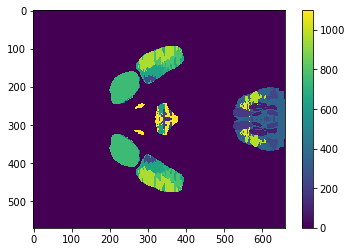

In [27]:
plt.imshow(im[361,:,:])
plt.colorbar()

In [44]:
df[df['annotation_index'] == 362]['annotation'].to_string().split('    ')[1]

'Mediodorsal nucleus of thalamus'

In [46]:
good_inds = np.where(im == 362)

In [52]:
np.where(good_inds[0] == ccf_ml_voxel-1)

(array([100351, 100352, 100353, ..., 104836, 104837, 104838]),)

In [56]:
np.where(good_inds[1] == ccf_dv_voxel-1)

(array([  2076,   2077,   2078, ..., 168161, 168162, 168163]),)

In [66]:
thalamus_use_nuclei = [
    'Anteromedial nucleus', #AN
    'Central medial nucleus of the thalamus', #CN
    'Mediodorsal nucleus of thalamus', #MD
    'Medial geniculate complex', #MGN
    'Paracentral nucleus', #PC
    'Parafascicular nucleus', #PF
    'Posterior complex of the thalamus', #PO
    'Paraventricular nucleus of the thalamus', #PVN
    'Reticular nucleus of the thalamus', #RT
    'Submedial nucleus of the thalamus', #SMN
    'Ventral anterior-lateral complex of the thalamus', #VAL
    'Ventral medial nucleus of the thalamus', #VM
    'Ventral posteromedial nucleus of the thalamus', #VPN
]

short_names = [
    'AN',
    'CN',
    'MD',
    'MGN',
    'PC',
    'PF',
    'PO',
    'PVN',
    'RT',
    'SMN',
    'VAL',
    'VM',
    'VPN',
]

short_names_correct_allen = [
    'AM',
    'CM',
    'MD',
    'MG',
    'PCN',
    'PF',
    'PO',
    'PVT',
    'RT',
    'SMT',
    'VAL',
    'VM',
    'VPM',    
]

cc = [
    "lightblue",  # A light shade of blue
    "skyblue",    # Reminiscent of a clear sky
    "steelblue",  # A cool, blue-gray shade
    "lightgreen", # A light, vibrant green
    "limegreen",  # Bright and vivid green
    "salmon",     # A soft, reddish-orange
    "tomato",     # A bright red-orange
    "coral",      # A soft, pinkish-orange
    "lavender",   # A soft, light purple
    "plum",       # A dark, rich purple
    "beige",      # A soft, pale sandy color
    "sienna",     # A reddish-brown earth tone
    "teal"        # A medium blue-green color
]

In [72]:
def get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds):
    subregions_annotation_dict = dict()
    for subreg in region_list:
        if subreg == 'ALM':
            continue
        else:
            subregions_annotation_dict[subreg] = func.get_all_subregion_annotations_from_name(df, subreg)['region'].values
    inds = func.get_neuron_inds_for_subregions(ccf_labels, subregions_annotation_dict)

    if 'ALM' in region_list:
        use_inds = dict()
        use_inds['ALM'] = alm_inds
        for k,v in inds.items():
            use_inds[k] = np.setdiff1d(v, alm_inds)
        
        return use_inds
    
    return inds

def create_one_epoch_barplots(ax, r2_new, inds, subregions_list, axis_names, cc,ylabel, quantity, r2_method = 'new', epoch = 'response', method_to_string = {'old':'_old', 'old_clipped':'_old', 'new':''}):
    n_neurons = [v.shape[0] for v in inds.values()]
    
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    if quantity == 'r2':
        m, sem = func.get_mean_and_sem_for_subregions(r2, inds, subregions_list)
    elif quantity == 'fr':
        m, sem = func.get_mean_and_sem_for_subregions(fr, inds, subregions_list)
    plt.bar(np.arange(0,len(m)), 
                m, yerr = sem, alpha = 0.8, color = cc, 
                capsize = 3, width=0.5, label = epoch)
    for i in range(len(n_neurons)):
        ax.text(i-0.1, m[i] + sem[i] + 0.1 * max(sem), 'n=%d' % n_neurons[i], fontsize=10, color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.legend()
    _ = ax.set_xticks(np.arange(0,len(m)))
    _ = ax.set_xticklabels(axis_names, rotation = 0)
    _ = ax.set_ylabel(ylabel)

def create_timeshift_curves_plot_single_epoch(ax, r2_new, timeshifts, inds, axis_names, cc, r2_method, epoch, method_to_string = {'old':'_old', 'old_clipped':'_old', 'new':''} ):
    r2 = []

    for timesh in timeshifts:
        r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%(epoch, method_to_string[r2_method])].copy())

    r2= np.array(r2)
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    ax.set_title('normalized timeshift curve, %s'%(epoch), fontsize = 16)
    for j, area in enumerate(inds.keys()):
        this_inds = inds[area]
        avg_r2 = r2[:,this_inds].mean(axis = 1)

        ax.plot(timeshifts*3.4, avg_r2/avg_r2[np.where(timeshifts == 0)[0][0]],color = cc[j], ls= 'solid', label = area + ', ' + epoch)

    a,b = ax.set_xlim()
    ax.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
    ax.set_xlim(a,b)

    a,b = ax.set_ylim()
    ax.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
    ax.set_ylim(a,b)

    ax.set_xlabel('Time shift (ms)', fontsize = 16)
    ax.set_ylabel('Normalized R2', fontsize = 16)

def create_timeshift_barplot_single_epoch(ax, r2_new, timeshifts, inds, axis_names, cc, r2_method, epoch, method_to_string = {'old':'_old', 'old_clipped':'_old', 'new':''}):
    r2 = []

    for timesh in timeshifts:
        r2.append(r2_new['5_%d'%timesh]['%s_r2%s'%(epoch, method_to_string[r2_method])].copy())

    r2= np.array(r2)
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    ax.set_title('Mean best timeshifts, %s'%(epoch), fontsize = 16)
    means = []
    sems = []
    for j, area in enumerate(inds.keys()):
        this_inds = inds[area]

        this_area_r2 = r2[:,this_inds]
        best_timeshift = np.argmax(this_area_r2, axis = 0)

        timeshift_array = 3.4 * timeshifts[best_timeshift]

        avg_timeshift = np.mean(timeshift_array)
        std_timeshift = np.std(timeshift_array)
        sem_timeshift = std_timeshift/np.sqrt(len(timeshift_array))
        means.append(avg_timeshift)
        sems.append(sem_timeshift)


    ax.bar(np.arange(len(means)), means, yerr = sems, color = cc, capsize = 3)
    _= ax.set_xticks(np.arange(len(means)))
    _ = ax.set_xticklabels(axis_names, rotation = 0)
    ax.set_ylabel('Mean best time shift (ms)', fontsize = 16)  


def create_timeshift_violin_plot_single_epoch(ax, r2_new, timeshifts, inds, axis_names, cc, r2_method, epoch, fr_threshold=5, r2_threshold=0.02, method_to_string={'old':'_old', 'old_clipped':'_old', 'new':''}):
    r2 = []
    fr = r2_new['5_0']['avg_fr'].copy()

    for timesh in timeshifts:
        r2.append(r2_new['5_%d' % timesh]['%s_r2%s' % (epoch, method_to_string[r2_method])].copy())

    r2 = np.array(r2)
    if r2_method == 'old_clipped':
        r2[r2 < 0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0], :] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)

    ax.set_title('%s' % (epoch), fontsize=16)

    data_to_plot = []
    for j, area in enumerate(inds.keys()):
        this_inds = inds[area]
        this_inds = np.intersect1d(this_inds, threshold_inds)
        this_area_r2 = r2[:, this_inds]
        best_timeshift = np.argmax(this_area_r2, axis=0)
        timeshift_array = 3.4 * timeshifts[best_timeshift]  # Assuming this is correct based on your code
        if len(timeshift_array) > 0:
            data_to_plot.append(timeshift_array)
        else:
            data_to_plot.append(np.array([0]))  # Append a zero array if no data

    # Creating violin plots
    parts = ax.violinplot(data_to_plot, points = 1000, showmeans=True, showmedians=False, bw_method=0.3)

    # Coloring each violin plot
    for ipc, pc in enumerate(parts['bodies']):
        pc.set_facecolor(cc[ipc])
        pc.set_edgecolor('black')
        pc.set_alpha(0.8)

    ax.set_xticks(np.arange(1, len(axis_names) + 1))
    ax.set_xticklabels(axis_names, rotation=0)
    ax.set_ylabel('Distribution of best time shift (ms)', fontsize=16)



def create_summary_plot(region_list, color_list, r2_new,ccf_labels, timeshifts, epochs, r2_method, axis_names, titlestr,alm_inds, epoch = 'response', method_to_string={'old':'_old', 'old_clipped':'_old', 'new':''}, fr_threshold = 5, r2_threshold = 0.02, delta_r2 = 1.2,  n_min = 0):
    inds = get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
    r2 = []
    fr = r2_new['5_0']['avg_fr'].copy()

    for timesh in timeshifts:
        r2.append(r2_new['5_%d' % timesh]['%s_r2%s' % (epoch, method_to_string[r2_method])].copy())

    r2 = np.array(r2)
    if r2_method == 'old_clipped':
        r2[r2 < 0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    #delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
    threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0], :] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)
    #threshold_inds = np.intersect1d(threshold_inds, delta_inds)

    _inds = {k: np.intersect1d(v, threshold_inds) for k, v in inds.items()}
    use_inds = {k: v for k,v in _inds.items() if v.shape[0] > n_min}

    use_regions = list(use_inds.keys())

    use_axis_names = [axis_names[i] for i in range(len(axis_names)) if region_list[i] in use_regions]
    f = plt.figure(figsize=(20,20))
    f.suptitle(titlestr + '%s, fr_min = %.2f, r2_min = %.3f, delta_r2 =%.2f'%(epoch,fr_threshold,r2_threshold,delta_r2), fontsize=20)

    ax_bar = f.add_subplot(2,2,1)
    create_one_epoch_barplots(ax_bar, r2_new, use_inds, use_regions , use_axis_names, color_list, 'Mean R2', 'r2', r2_method, epoch,)

    ax_bar = f.add_subplot(2,2,2)
    create_one_epoch_barplots(ax_bar, r2_new, use_inds, use_regions , use_axis_names, color_list, 'Mean FR', 'fr', r2_method, epoch,)

    ax_bar = f.add_subplot(2,2,3)
    create_timeshift_curves_plot_single_epoch(ax_bar, r2_new, timeshifts, use_inds, use_axis_names, color_list, r2_method, epoch)

    ax_bar = f.add_subplot(2,2,4)
    create_timeshift_barplot_single_epoch(ax_bar, r2_new, timeshifts, use_inds, use_axis_names, color_list, r2_method, epoch,)
    plt.subplots_adjust(top=0.95)


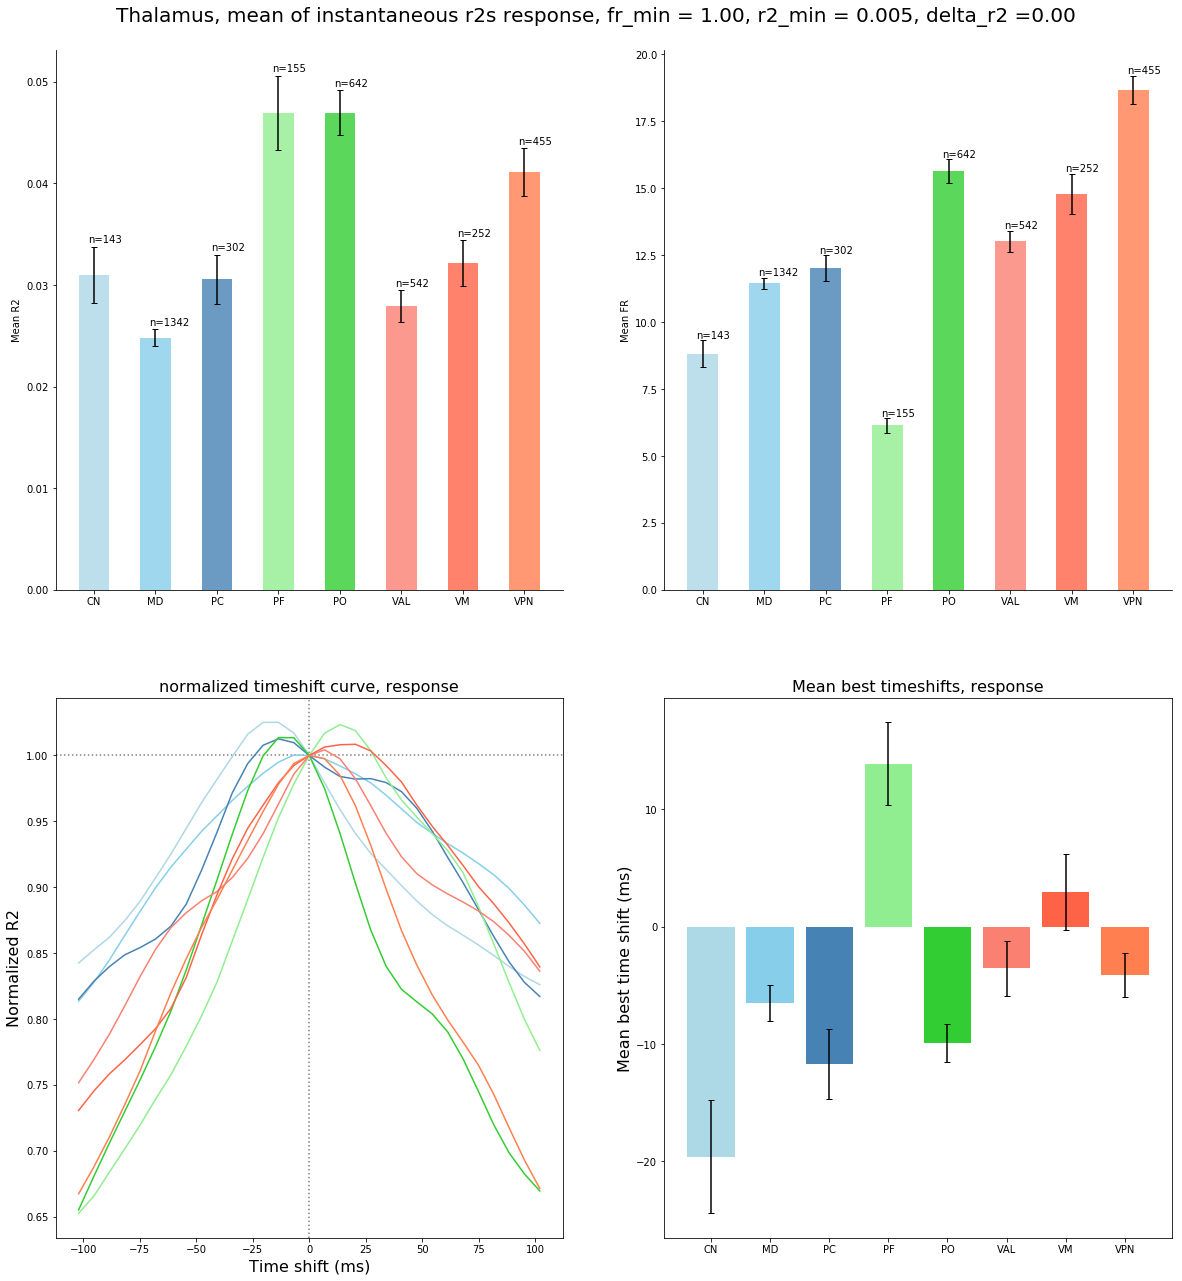

In [73]:
create_summary_plot(thalamus_use_nuclei, cc, r2_new,ccf_labels, timeshifts, epochs,alm_inds=alm_inds, r2_method = 'new', axis_names = short_names, titlestr = 'Thalamus, mean of instantaneous r2s ', method_to_string = method_to_string, r2_threshold=0.005, fr_threshold=1.0, delta_r2=0.,n_min= 90)


In [132]:
def get_mean_r2_and_fr_for_regions(r2_new, df, ccf_labels, alm_inds, region_list, method_to_string, r2_method = "new", epoch = "response", fr_threshold = 2, r2_threshold = 0.01, delta_r2 = 0, n_min = 100):

    inds = get_inds_for_list_of_regions(region_list, df, ccf_labels, alm_inds)
    r2 = []
    fr = r2_new['5_0']['avg_fr'].copy()

    for timesh in timeshifts:
        r2.append(r2_new['5_%d' % timesh]['%s_r2%s' % (epoch, method_to_string[r2_method])].copy())

    r2 = np.array(r2)
    if r2_method == 'old_clipped':
        r2[r2 < 0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    #delta_inds = np.where((r2.max(axis = 0) / r2.mean(axis = 0)) > delta_r2)[0]
    threshold_inds = np.where(r2[np.where(timeshifts == 0)[0][0], :] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)
    #threshold_inds = np.intersect1d(threshold_inds, delta_inds)

    _inds = {k: np.intersect1d(v, threshold_inds) for k, v in inds.items()}
    use_inds = {k: v for k,v in _inds.items() if v.shape[0] > n_min}
    use_regions = list(use_inds.keys())

    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    
    r2m, r2sem = func.get_mean_and_sem_for_subregions(r2, use_inds, use_regions)

    frm, frsem = func.get_mean_and_sem_for_subregions(fr, use_inds, use_regions)

    return r2m, r2sem, frm, frsem, use_inds

In [281]:
class Annotation_from_Coords():
    def __init__(self, datafolder = '../data/', tif_name = 'Annotation_new_10_ds222_32bit.tif', csv_name = 'mousebrainontology_2.csv'):
        self.image_data = self.load_tif_fast(datafolder + tif_name)
        self.df = pd.read_csv(datafolder + csv_name, header = None,names = ['annotation_index', 'annotation'])

    def load_tif_fast(self, file_tif):
        from PIL import Image
        print(f'Loading {file_tif}...')
        # Open the TIF file
        with Image.open(file_tif) as img:
            # Extract image dimensions and frames
            xpix, ypix = img.size
            frames = img.n_frames
            
            # Determine bit depth and data type
            mode_to_bitdepth = {
                'L': 8,    # 8-bit pixels, grayscale
                'P': 8,    # 8-bit pixels, mapped to any other mode using a color palette
                'I;16': 16, # 16-bit pixels, grayscale
                'I;16B': 16, # 16-bit pixels, big endian
                'I': 32,   # 32-bit signed integer pixels
                'F': 32    # 32-bit floating point pixels
            }
            
            bitdepth = mode_to_bitdepth.get(img.mode, None)
            if bitdepth == 32:
                dtype = np.uint32
            elif bitdepth == 16:
                dtype = np.uint16
            elif bitdepth == 8:
                dtype = np.uint8
            else:
                raise ValueError("Unsupported bit depth")
            
            # Initialize empty array to hold image data
            im = np.zeros((ypix, xpix, frames), dtype=dtype)
            
            for i in range(frames):
                img.seek(i)  # Move to the specified frame
                im[:, :, i] = np.array(img)
        
        print('Done loading Tif')
        return im
    
    def get_annotation(self, ccf_ml, ccf_dv, ccf_ap, reso = 20):
        ccf_ml_voxel = int(ccf_ml / reso)
        ccf_dv_voxel = int(ccf_dv / reso)
        ccf_ap_voxel = int(ccf_ap / reso)
        annotation_index = self.image_data[ccf_ml_voxel, ccf_dv_voxel, ccf_ap_voxel]
        if annotation_index == 0:
            return 'Outside CCF'
        if annotation_index in self.df['annotation_index'].values:
            annotation = self.df.loc[self.df['annotation_index'] == annotation_index, 'annotation'].values[0]
        else:
            annotation = 'No annotation'
        return annotation
    
annot = Annotation_from_Coords()

Loading ../data/Annotation_new_10_ds222_32bit.tif...
Done loading Tif


In [276]:
noise_scale = 0
ccf_coords_new = ccf_coords.copy() + np.random.normal(0, noise_scale, ccf_coords.shape)
ccf_labels_new = np.array([annot.get_annotation(ccf_coords[i,1], ccf_coords[i,0], ccf_coords[i,2], reso = 20) for i in range(ccf_coords_new.shape[0])])
np.sum(ccf_labels_new == ccf_labels)

526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184


40207

In [277]:
noise_scale = 0
ccf_coords_new = ccf_coords.copy() + np.random.normal(0, noise_scale, ccf_coords.shape)
ccf_labels_new = np.array([annot.get_annotation(ccf_coords[i,1], ccf_coords[i,0], ccf_coords[i,2]) for i in range(ccf_coords_new.shape[0])])
np.sum(ccf_labels_new == ccf_labels)

526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184
526157184


40207

In [262]:
len(ccf_labels_new)

41284

In [270]:
np.unique(ccf_labels[ccf_labels_new == 'No annotation'])

array(['Frontal pole, layer 5', 'Frontal pole, layer 6a',
       'Primary somatosensory area, unassigned, layer 2/3',
       'Primary somatosensory area, unassigned, layer 4',
       'Primary somatosensory area, unassigned, layer 5',
       'Primary somatosensory area, unassigned, layer 6a'], dtype='<U66')

In [274]:
np.unique(ccf_labels[ccf_labels_new == 'No annotation'])[3] in annot.df['annotation']

False

In [259]:
np.sum(ccf_labels_new == 'No annotation')

1032

In [260]:
np.sum(ccf_labels_new == 'No annotation')

1032

In [261]:
np.sum(ccf_labels_new == 'Outside CCF')

0

In [249]:
np.sum(ccf_labels_new == 'Outside CCF')

3

In [239]:
ccf_coords

array([[5680, 4760, 6920],
       [5680, 4780, 6920],
       [5680, 4740, 6920],
       ...,
       [3240, 4460, 4620],
       [3340, 4240, 4620],
       [3360, 4200, 4620]])

In [240]:
sessions = r2_new['5_0']['session_name'].copy()

In [241]:
(ccf_labels_new != ccf_labels)

array([False, False, False, ..., False, False, False])

In [263]:
sessions = r2_new['5_0']['session_name'].copy()
unique_sessions = np.unique(sessions)
mismatch_per_sess = {}
match_per_sess = {}
for sess in unique_sessions:
    mismatch_per_sess[sess] = np.sum(
        (sessions == sess) * (ccf_labels_new != ccf_labels)
    )
    match_per_sess[sess] = np.sum(
        (sessions == sess) * (ccf_labels_new == ccf_labels)
    )

mismatch_per_sess

{'SC026_20190805_21': 56,
 'SC026_20190806_22': 58,
 'SC026_20190808_23': 51,
 'SC027_20190729_17': 5,
 'SC027_20190730_18': 22,
 'SC027_20190731_19': 54,
 'SC027_20190801_20': 37,
 'SC027_20190803_21': 0,
 'SC027_20190804_22': 0,
 'SC030_20191003_33': 0,
 'SC030_20191004_34': 49,
 'SC030_20191005_35': 35,
 'SC031_20191021_48': 38,
 'SC031_20191023_50': 5,
 'SC032_20191218_55': 40,
 'SC032_20191219_56': 61,
 'SC032_20191220_57': 4,
 'SC033_20191113_32': 19,
 'SC033_20191114_33': 19,
 'SC033_20191115_34': 0,
 'SC035_20200107_33': 40,
 'SC035_20200108_34': 0,
 'SC035_20200109_35': 26,
 'SC035_20200110_36': 10,
 'SC038_20191119_4': 3,
 'SC038_20191119_5': 4,
 'SC038_20191120_6': 2,
 'SC038_20191120_7': 0,
 'SC038_20191121_8': 0,
 'SC038_20191121_9': 0,
 'SC038_20191122_10': 6,
 'SC038_20191122_11': 10,
 'SC038_20191123_12': 7,
 'SC038_20191123_13': 10,
 'SC043_20200922_24': 9,
 'SC043_20200923_25': 12,
 'SC043_20200924_26': 2,
 'SC043_20200925_27': 5,
 'SC045_20201210_18': 4,
 'SC045_2020

In [242]:
unique_sessions = np.unique(sessions)
mismatch_per_sess = {}
match_per_sess = {}
for sess in unique_sessions:
    mismatch_per_sess[sess] = np.sum(
        (sessions == sess) * (ccf_labels_new != ccf_labels)
    )
    match_per_sess[sess] = np.sum(
        (sessions == sess) * (ccf_labels_new == ccf_labels)
    )

mismatch_per_sess

{'SC026_20190805_21': 271,
 'SC026_20190806_22': 242,
 'SC026_20190808_23': 277,
 'SC027_20190729_17': 98,
 'SC027_20190730_18': 308,
 'SC027_20190731_19': 265,
 'SC027_20190801_20': 177,
 'SC027_20190803_21': 29,
 'SC027_20190804_22': 33,
 'SC030_20191003_33': 129,
 'SC030_20191004_34': 197,
 'SC030_20191005_35': 181,
 'SC031_20191021_48': 361,
 'SC031_20191023_50': 83,
 'SC032_20191218_55': 222,
 'SC032_20191219_56': 258,
 'SC032_20191220_57': 106,
 'SC033_20191113_32': 73,
 'SC033_20191114_33': 66,
 'SC033_20191115_34': 50,
 'SC035_20200107_33': 253,
 'SC035_20200108_34': 132,
 'SC035_20200109_35': 167,
 'SC035_20200110_36': 108,
 'SC038_20191119_4': 34,
 'SC038_20191119_5': 22,
 'SC038_20191120_6': 27,
 'SC038_20191120_7': 34,
 'SC038_20191121_8': 60,
 'SC038_20191121_9': 11,
 'SC038_20191122_10': 81,
 'SC038_20191122_11': 112,
 'SC038_20191123_12': 167,
 'SC038_20191123_13': 152,
 'SC043_20200922_24': 155,
 'SC043_20200923_25': 234,
 'SC043_20200924_26': 189,
 'SC043_20200925_27':

In [251]:
sess_df = pd.DataFrame({'session_id': match_per_sess.keys(), 'match label': match_per_sess.values(), 'mismatch label': mismatch_per_sess.values()})
sess_df.to_csv(datafolder + 'session_label_match.csv', index = False)

In [243]:
match_per_sess

{'SC026_20190805_21': 241,
 'SC026_20190806_22': 296,
 'SC026_20190808_23': 327,
 'SC027_20190729_17': 127,
 'SC027_20190730_18': 173,
 'SC027_20190731_19': 239,
 'SC027_20190801_20': 262,
 'SC027_20190803_21': 404,
 'SC027_20190804_22': 395,
 'SC030_20191003_33': 143,
 'SC030_20191004_34': 228,
 'SC030_20191005_35': 169,
 'SC031_20191021_48': 180,
 'SC031_20191023_50': 96,
 'SC032_20191218_55': 127,
 'SC032_20191219_56': 137,
 'SC032_20191220_57': 80,
 'SC033_20191113_32': 78,
 'SC033_20191114_33': 126,
 'SC033_20191115_34': 91,
 'SC035_20200107_33': 131,
 'SC035_20200108_34': 123,
 'SC035_20200109_35': 164,
 'SC035_20200110_36': 163,
 'SC038_20191119_4': 72,
 'SC038_20191119_5': 135,
 'SC038_20191120_6': 190,
 'SC038_20191120_7': 160,
 'SC038_20191121_8': 284,
 'SC038_20191121_9': 242,
 'SC038_20191122_10': 262,
 'SC038_20191122_11': 365,
 'SC038_20191123_12': 165,
 'SC038_20191123_13': 290,
 'SC043_20200922_24': 225,
 'SC043_20200923_25': 311,
 'SC043_20200924_26': 188,
 'SC043_2020

In [206]:
new_df = pd.DataFrame({'ccf_ml': ccf_coords[:,1], 'ccf_dv': ccf_coords[:,0], 'ccf_ap': ccf_coords[:,2], 'ccf_labels_original': ccf_labels, 'ccf_labels_new': ccf_labels_new})
new_df.head()

new_df.to_csv(datafolder + 'ccf_coords_with_annotations.csv', columns=['ccf_ml', 'ccf_dv', 'ccf_ap', 'ccf_labels_original', 'ccf_labels_new'], index=False)

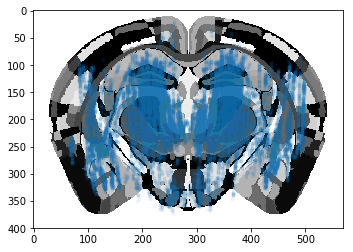

In [181]:
plt.plot(ccf_coords[:,0]/20, ccf_coords[:,1]/20, '.', alpha = .05)
plt.imshow(im[:,:,360], cmap = 'Greys', vmax = 1000)

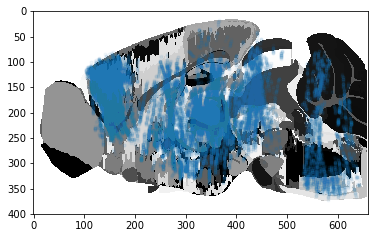

In [185]:
plt.plot(ccf_coords[:,2]/20, ccf_coords[:,1]/20, '.', alpha = .05)
plt.imshow(im[:,300,:], cmap = 'Greys', vmax = 1000)

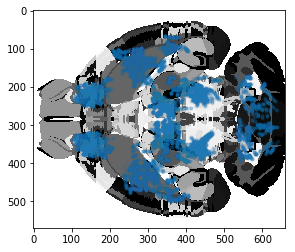

In [188]:
plt.plot(ccf_coords[:,2]/20, ccf_coords[:,0]/20, '.', alpha = .05)
plt.imshow(im[200,:,:], cmap = 'Greys', vmax = 1000)

In [124]:
0 in annot.df['annotation_index'].values

False

In [192]:
np.sum(ccf_labels_new == ccf_labels)

25286

In [244]:
ccf_labels[:40]

array(['Rhomboid nucleus', 'Rhomboid nucleus', 'Rhomboid nucleus',
       'Rhomboid nucleus', 'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral anterior-lateral complex of the thalamus',
       'Ventral anterior-lateral complex of the thalamus',
       'Ventral anterior-lateral complex of the thalamus',
       'Ventral anterior-lateral complex of the thalamus',
       'Ventral anterior-lateral complex of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral anterior-lateral complex of the thalamus',
       'Ventral anterior-lateral complex of the thalamus',
       'Ventral anterior-lateral complex of the thalamus',


In [245]:
ccf_labels_new[:40]

array(['Rhomboid nucleus', 'Rhomboid nucleus', 'Rhomboid nucleus',
       'Rhomboid nucleus', 'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral anterior-lateral complex of the thalamus',
       'Ventral anterior-lateral complex of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral medial nucleus of the thalamus',
       'Ventral anterior-lateral complex of the thalamus',
       'Ventral anterior-lateral complex of the thalamus',
       'Ventral anterior-lateral complex of the thalamus',
       'Ventral anterior-later

In [264]:

r2_mean, r2_sem, fr_mean, fr_sem, use_inds = get_mean_r2_and_fr_for_regions(r2_new, df, ccf_labels, alm_inds, thalamus_use_nuclei, method_to_string, r2_method = "new", epoch = "response", fr_threshold = 2, r2_threshold = 0.01, delta_r2 = 0, n_min = 100)

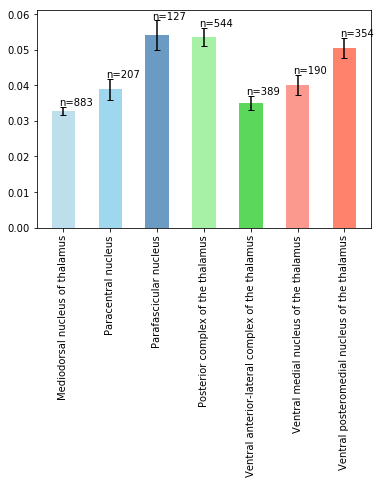

In [265]:
plt.bar(list(use_inds.keys()),
            r2_mean, yerr = r2_sem, alpha = 0.8, color = cc, 
            capsize = 3, width=0.5, label = 'response')
plt.xticks(rotation = 90)
n_neurons = [v.shape[0] for v in use_inds.values()]
for i in range(len(list(use_inds.keys()))):
    plt.text(i-0.1, r2_mean[i] + r2_sem[i] + 0.1 * max(r2_sem), 'n=%d' % n_neurons[i], fontsize=10, color='black')

<BarContainer object of 7 artists>

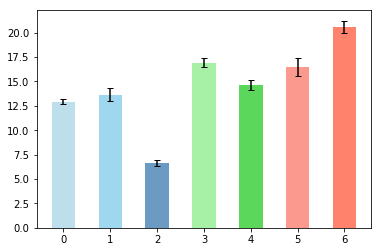

In [266]:
plt.bar(np.arange(0,len(r2_mean)),
            fr_mean, yerr = fr_sem, alpha = 0.8, color = cc, 
            capsize = 3, width=0.5, label = 'response')

In [267]:

r2_mean, r2_sem, fr_mean, fr_sem, use_inds = get_mean_r2_and_fr_for_regions(r2_new, df, ccf_labels_new, alm_inds, thalamus_use_nuclei, method_to_string, r2_method = "new", epoch = "response", fr_threshold = 2, r2_threshold = 0.01, delta_r2 = 0, n_min = 100)

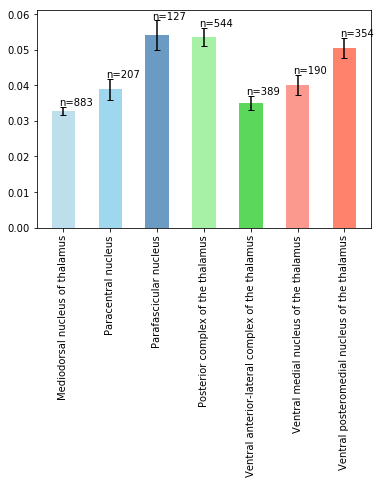

In [268]:
plt.bar(list(use_inds.keys()),
            r2_mean, yerr = r2_sem, alpha = 0.8, color = cc, 
            capsize = 3, width=0.5, label = 'response')
plt.xticks(rotation = 90)
n_neurons = [v.shape[0] for v in use_inds.values()]
for i in range(len(list(use_inds.keys()))):
    plt.text(i-0.1, r2_mean[i] + r2_sem[i] + 0.1 * max(r2_sem), 'n=%d' % n_neurons[i], fontsize=10, color='black')

In [200]:
alm_inds.shape

(4977,)

<BarContainer object of 7 artists>

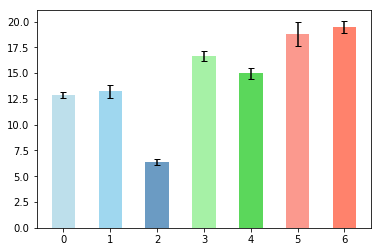

In [131]:
plt.bar(np.arange(0,len(r2_mean)),
            fr_mean, yerr = fr_sem, alpha = 0.8, color = cc, 
            capsize = 3, width=0.5, label = 'response')

In [293]:
thalamus_use_nuclei = [
    #'Anteromedial nucleus', #AN
    'Central medial nucleus of the thalamus', #CN
    'Mediodorsal nucleus of thalamus', #MD
    #'Medial geniculate complex', #MGN
    'Paracentral nucleus', #PC
    'Parafascicular nucleus', #PF
    'Posterior complex of the thalamus', #PO
    #'Paraventricular nucleus of the thalamus', #PVN
    #'Reticular nucleus of the thalamus', #RT
    #'Submedial nucleus of the thalamus', #SMN
    'Ventral anterior-lateral complex of the thalamus', #VAL
    'Ventral medial nucleus of the thalamus', #VM
    'Ventral posteromedial nucleus of the thalamus', #VPN
]

In [294]:
noise_scales = [0, 5, 10, 20, 25, 50, 100]
r2_means = [[] for i in range(len(noise_scales))]
r2_sems = [[] for i in range(len(noise_scales))]
fr_means = [[] for i in range(len(noise_scales))]
fr_sems = [[] for i in range(len(noise_scales))]
n_neurons = [[] for i in range(len(noise_scales))]

np.random.seed(0)
for i,noise_scale in enumerate(noise_scales):

    for j in range(20):

        ccf_coords_new = ccf_coords.copy() + np.random.normal(0, noise_scale, ccf_coords.shape)
        ccf_labels_new = np.array([annot.get_annotation(ccf_coords_new[i,1], ccf_coords_new[i,0], ccf_coords_new[i,2]) for i in range(ccf_coords_new.shape[0])])

        r2_mean, r2_sem, fr_mean, fr_sem, use_inds = get_mean_r2_and_fr_for_regions(r2_new, df, ccf_labels_new, alm_inds, thalamus_use_nuclei, method_to_string, r2_method = "new", epoch = "response", fr_threshold = 2, r2_threshold = 0.01, delta_r2 = 0, n_min = 1)
        r2_means[i].append(r2_mean)
        r2_sems[i].append(r2_sem)
        fr_means[i].append(fr_mean)
        fr_sems[i].append(fr_sem)
        n_neurons[i].append([v.shape[0] for v in use_inds.values()])

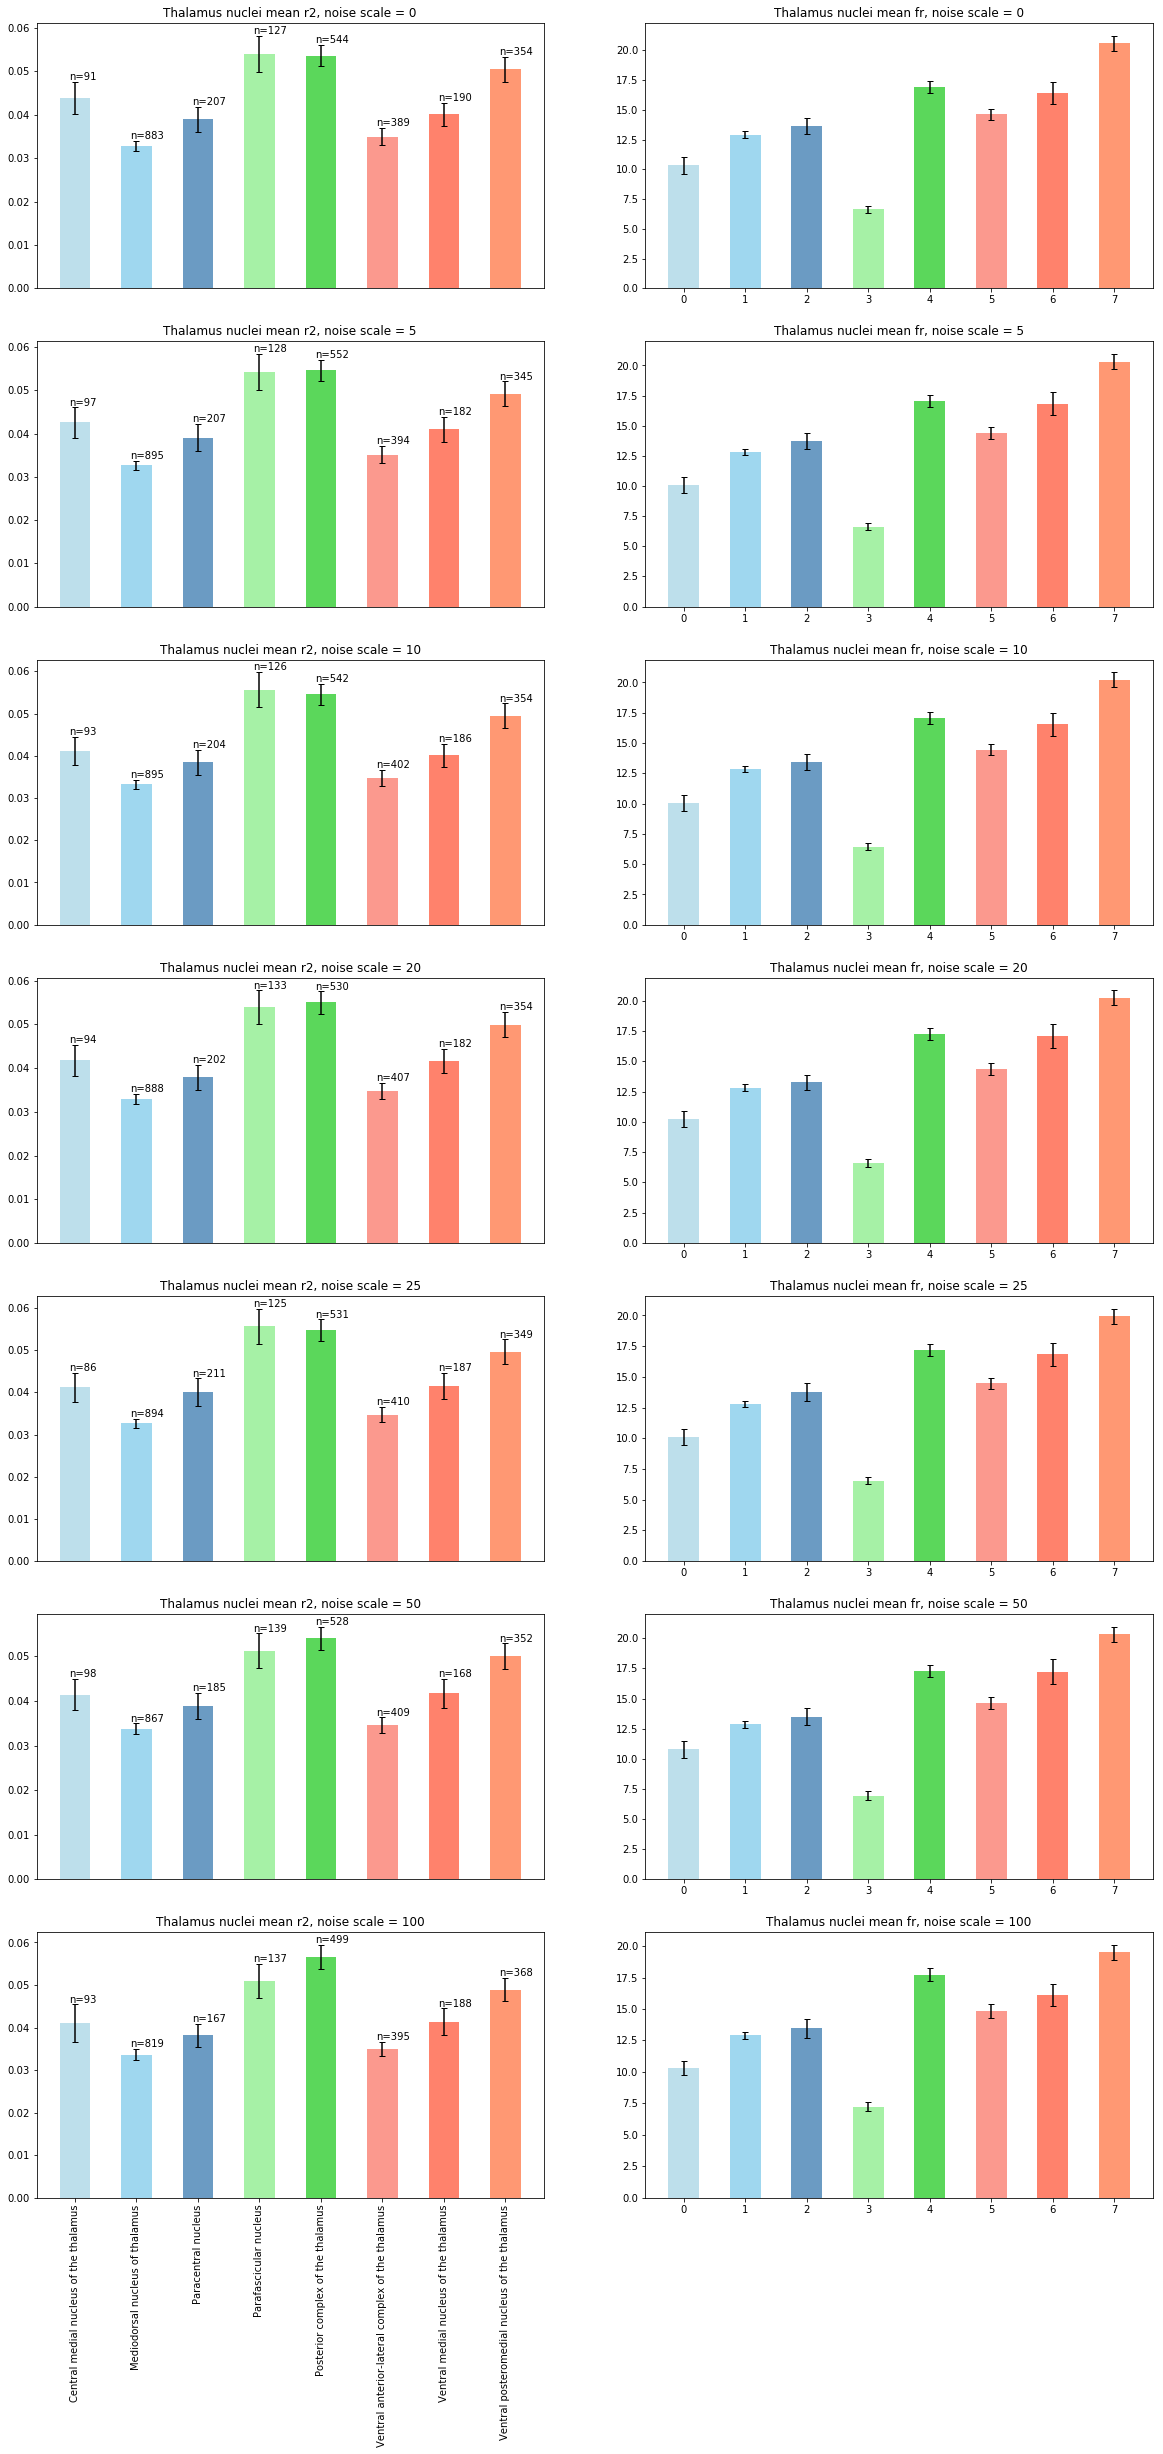

In [279]:
plt.subplots(len(noise_scales),2, figsize = (20,40))

for i in range(len(noise_scales)):
    plt.subplot(len(noise_scales),2,2*i+1)
    plt.title('Thalamus nuclei mean r2, noise scale = %d'%noise_scales[i])
    plt.bar(list(use_inds.keys()),
                r2_means[i], yerr = r2_sems[i], alpha = 0.8, color = cc, 
                capsize = 3, width=0.5, label = 'response')
    if i == len(noise_scales) - 1:
        plt.xticks(rotation = 90)
    else:
        plt.xticks([])
    for j in range(len(list(use_inds.keys()))):
        plt.text(j-0.1, r2_means[i][j] + r2_sems[i][j] + 0.1 * max(r2_sems[i]), 'n=%d' % n_neurons[i][j], fontsize=10, color='black')

    plt.subplot(len(noise_scales),2,2*i+2)
    plt.title('Thalamus nuclei mean fr, noise scale = %d'%noise_scales[i])
    plt.bar(np.arange(0,len(r2_means[i])),
                fr_means[i], yerr = fr_sems[i], alpha = 0.8, color = cc, 
                capsize = 3, width=0.5, label = 'response')
    
    plt.savefig(figfolder + 'thalamus_nuclei_noise_scales.png', dpi = 300)

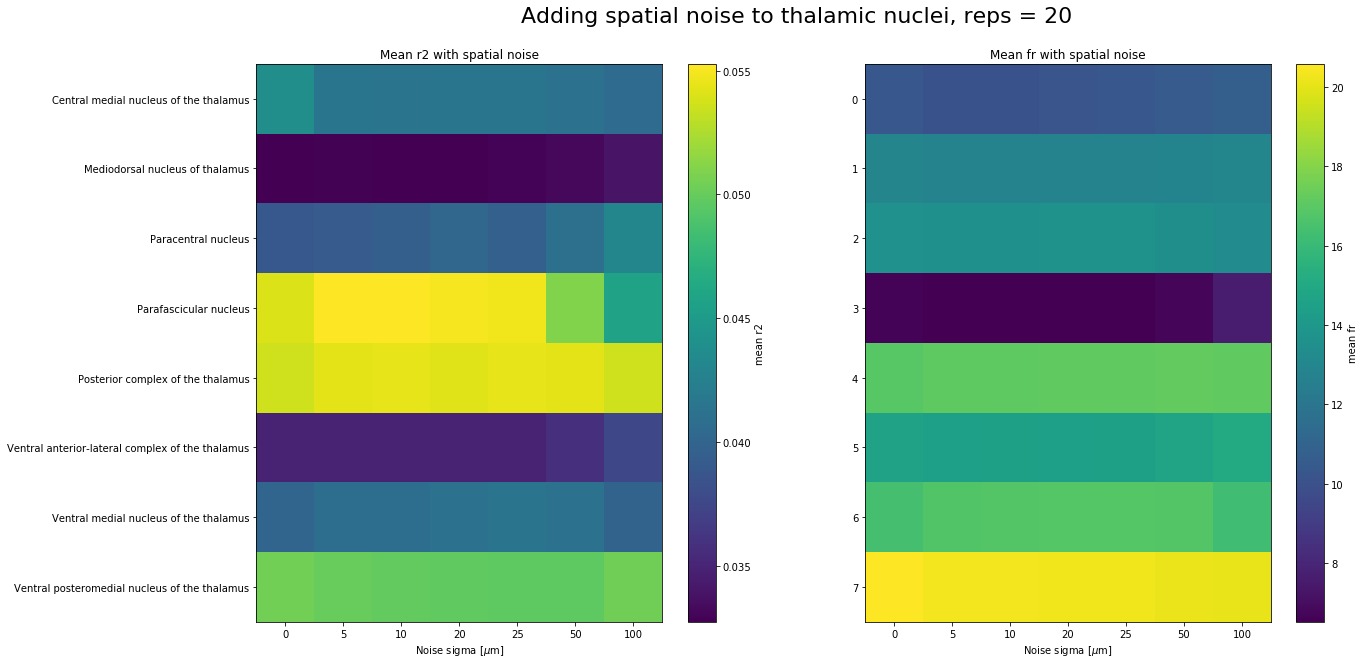

In [307]:
f,_ = plt.subplots(1,2, figsize = (20,10))
f.suptitle('Adding spatial noise to thalamic nuclei, reps = 20', fontsize = 22)

plt.subplot(1,2,1)
plt.title('Mean r2 with spatial noise')
plt.imshow(np.array([np.mean(np.array(_reps), axis = 0) for _reps in r2_means]).T, aspect = 'auto')
plt.colorbar(label = 'mean r2')
plt.xticks(np.arange(0,len(noise_scales)), noise_scales)
plt.xlabel(r'Noise sigma [$\mu$m]')
plt.yticks(np.arange(0,len(use_inds.keys())), use_inds.keys(), rotation = 0)

plt.subplot(1,2,2)
plt.title('Mean fr with spatial noise')
plt.imshow(np.array([np.mean(np.array(_reps), axis = 0) for _reps in fr_means]).T, aspect = 'auto')
plt.colorbar(label = 'mean fr')
plt.xticks(np.arange(0,len(noise_scales)), noise_scales)
plt.xlabel(r'Noise sigma [$\mu$m]')

plt.subplots_adjust(top=0.9)
plt.savefig(figfolder + 'spatial_noise_heatmap_20reps.png', dpi = 300, bbox_inches = 'tight')

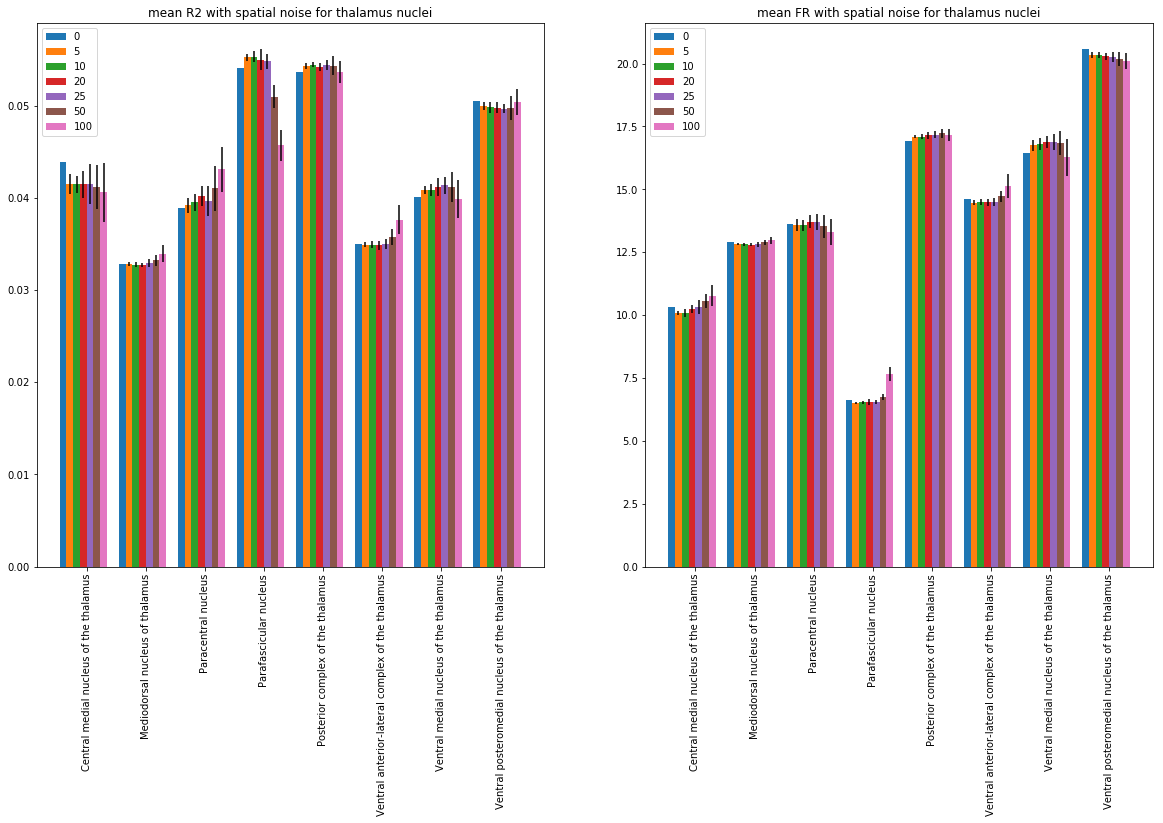

In [308]:
plt.subplots(1,2, figsize = (20,10))

plt.subplot(1,2,1)
plt.title('mean R2 with spatial noise for thalamus nuclei')
for i in range(7):
    plt.bar(np.arange(len(thalamus_use_nuclei))-0.4+0.8/7*i, np.mean(np.array(r2_means[i]), axis = 0), width=0.8/7, yerr = np.std(np.array(r2_means[i]), axis = 0), label = noise_scales[i])
plt.xticks(np.arange(len(thalamus_use_nuclei)), thalamus_use_nuclei, rotation = 90)
plt.legend()

plt.subplot(1,2,2)
plt.title('mean FR with spatial noise for thalamus nuclei')
for i in range(7):
    plt.bar(np.arange(len(thalamus_use_nuclei))-0.4+0.8/7*i, np.mean(np.array(fr_means[i]), axis = 0), width=0.8/7, yerr = np.std(np.array(fr_means[i]), axis = 0), label = noise_scales[i])
plt.xticks(np.arange(len(thalamus_use_nuclei)), thalamus_use_nuclei, rotation = 90)
plt.legend()

plt.savefig(figfolder + 'spatial_noise_barplot_20reps.png', dpi = 300, bbox_inches = 'tight')